In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import torch
from torchvision import models
import torchvision.transforms.v2 as transforms
from torchvision.transforms import InterpolationMode
import random
from torch import nn, optim
from typing import overload
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Optional for better visualization


# import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

cuda


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

Report: 
Data Analysis and Preprocessing

    Feature Extraction and Histogram Analysis:
        Examined the following features through histograms- Duration, Width, Height, and FPS. 

        Based on the hostogram analysis: 
            Video Duration: Limited variation in durations. Shortening videos won't significantly affect content quality.
            Resolution: Notable clustering into two groups. Adjustments needed for split-screen footage, cropped images, and orientation differences.
            Frame Rate (FPS): Significant variation in FPS across videos, suggesting the need for frame rate standardization.

Standardization Methodology

    Based on the histogram analysis, we adopted the following standardization methods:
        1. Frame Rate: Standardized to the lowest FPS in the dataset for computational efficiency.
        2. Resolution: Adopted the most common resolution.
        3. Video Duration: Trimmed all videos to match the shortest video, with potential for future adjustments.
        4. DataHandler Implementation: Created to sub-sample videos, adjust resolution, and save processed videos in .npy.
        5. Verification: Used npy2mp4 function to convert processed .npy files back to .mp4 format to ensure correct preprocessing. 

Model Selection and Preparation

    We chose the Video Swin Transformer from PyTorch, due to its proficiency in handling spatiotemporal features in video data.

    Model Preparation:
        Investigated the model's input requirements and necessary data transformations.
        Data Transformer Class: Developed a custom class for video data preprocessing, including resizing, cropping, and normalization, specifically designed for our model.
        Integrated this transformer within the DataLoader class, enabling efficient data handling and preparation.

DataLoader Class and Data Handling

    Implemented data splitting based on a predefined ratio for creating training and test datasets.
    Incorporated a generator mechanism for batch-wise data processing, crucial for handling large datasets efficiently.
    Provided an option to save datasets directly from the generator to a designated directory, enhancing flexibility in data management.

Model Class Development and Training Process

    Model Class:
        Designed to encapsulate the chosen Swin Transformer model, tailored for classification tasks.
        Incorporated methods for training (train), testing (test), and classifying (classify) inputs.

    Training and Evaluation:
        Conducted training over several epochs, tracking loss and accuracy metrics.
        During testing, evaluated the model's performance and calculated a confusion matrix for a detailed understanding of classification results.
        Plotted performance metrics like loss and accuracy, providing visual insights into the model's learning progression.

    Confusion Matrix:
        Implemented a method to generate and visualize the confusion matrix, aiding in the assessment of the model's classification prowess.
        Utilized class names loaded from a JSON file for meaningful representation in the confusion matrix.


In [2]:
def get_video_metadata(filepath, exercise_name, execise_type):
    """
    Extracts metadata from a video file.

    This function opens a video file and extracts its properties such as width, height, 
    frames per second, total frame count, and duration. The function then compiles this information
    into a dictionary.

    Parameters:
        filepath (str): The path to the video file.
        exercise_name (str): The name of the video.
        exercise_type (str): The type of the exercise.

    Returns:
        dict: A dictionary containing the video's metadata, including its full path, filename,
              exercise type, duration in seconds, width, height, FPS, and frame count. 
              Returns None if the video cannot be opened.
    """

    cap = cv2.VideoCapture(filepath)

    if not cap.isOpened():
        print(f"Error: Could not open video {filepath}.")
        return None

    # Get video properties
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    cap.release()

    res = {
        "Full path": filepath,
        "Filename": exercise_name,
        "Exercise": execise_type,
        "Duration (seconds)": duration,
        "Width": width,
        "Height": height,
        "FPS": fps,
        "Frame Count": frame_count
        }

    return res

In [3]:
def create_video_dataframe(video_folder):
    """
    Creates a DataFrame containing metadata for each video in a specified folder.

    Walks through the video folder, extracts metadata from each video file,
    and compiles this information into a DataFrame. If a metadata CSV file already exists
    in the folder, it reads and returns the DataFrame from the file instead of recreating it.

    Parameters:
        video_folder (str): The path to the folder containing video files.

    Returns:
        pd.DataFrame: A DataFrame containing metadata of the videos.
    """
    
    metadata_file = os.path.join(video_folder, "metadata.csv")

    # Check if metadata already exists
    if os.path.exists(metadata_file):
        return pd.read_csv(metadata_file)

    # List to hold video metadata
    video_data = []
    extensions = ['.mp4', '.mov']

    # Iterate over each video in the folder
    for root, dirs, files in os.walk(video_folder):
        for filename in files:
            if any(filename.endswith(ext) for ext in extensions):
                filepath = os.path.join(root, filename)
                exercise = os.path.basename(root)
                metadata = get_video_metadata(filepath, filename, exercise)
                if metadata:
                    video_data.append(metadata)

    # Create DataFrame from video metadata
    df = pd.DataFrame(video_data)
    # Save metadata to CSV
    df.to_csv(metadata_file, index=False)
    return df



video_folder = "data/raw_data/"
meta_data = create_video_dataframe(video_folder)
print(meta_data[:5])



   Unnamed: 0                                          Full path  \
0           0  data/raw_data/barbell biceps curl\barbell bice...   
1           1  data/raw_data/barbell biceps curl\barbell bice...   
2           2  data/raw_data/barbell biceps curl\barbell bice...   
3           3  data/raw_data/barbell biceps curl\barbell bice...   
4           4  data/raw_data/barbell biceps curl\barbell bice...   

                     Filename             Exercise  Duration (seconds)  \
0   barbell biceps curl_1.mp4  barbell biceps curl            3.803800   
1  barbell biceps curl_10.mp4  barbell biceps curl            3.136467   
2  barbell biceps curl_11.mp4  barbell biceps curl            2.502500   
3  barbell biceps curl_12.mp4  barbell biceps curl            4.104100   
4  barbell biceps curl_13.mp4  barbell biceps curl            4.070733   

    Width  Height       FPS  Frame Count  
0  1920.0  1080.0  29.97003          114  
1  1920.0  1080.0  29.97003           94  
2  1920.0  1080.0

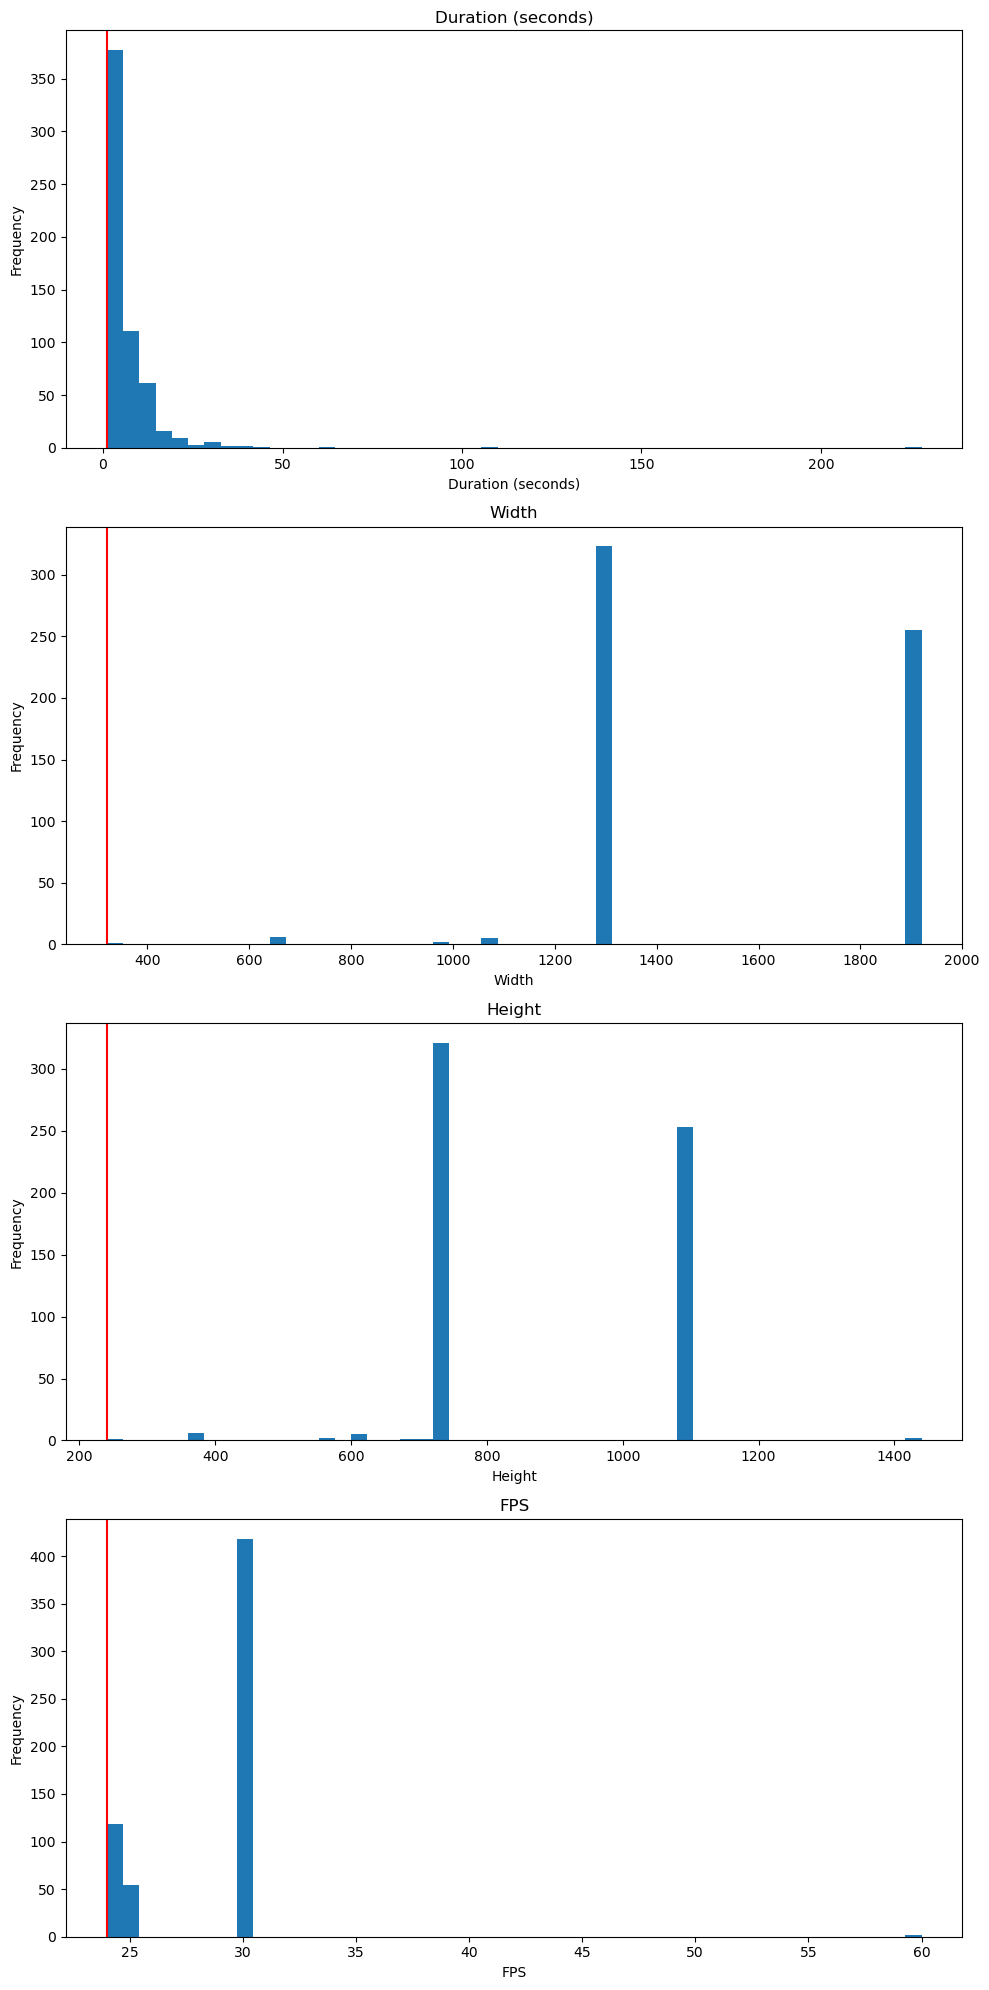

The initial summarry of the data is:


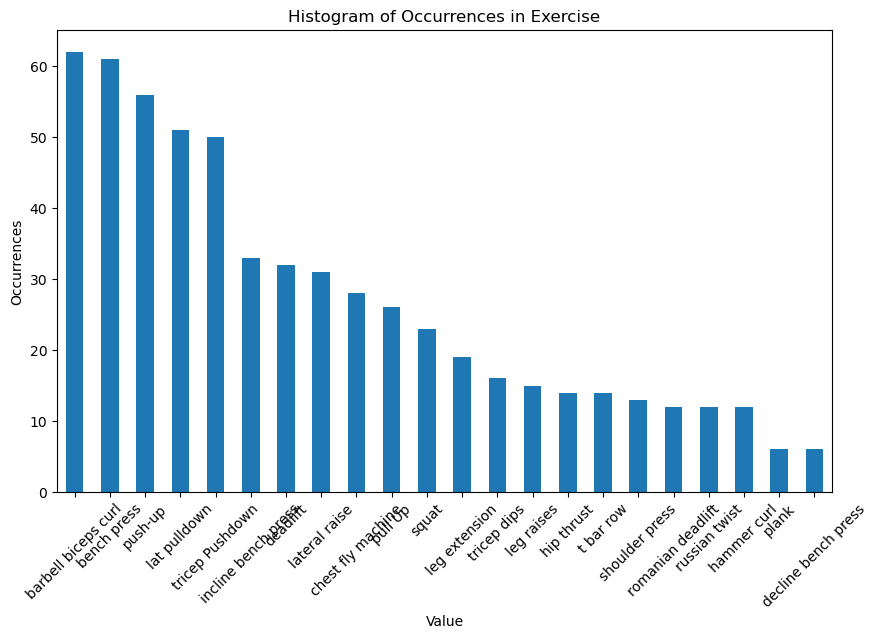

In [4]:
# Filter out the columns that are not in the DataFrame
columns = ["Duration (seconds)", "Width", "Height", "FPS"]

# Number of valid columns
num_columns = len(columns)

# Set up the matplotlib figure
# Creating subplots for each column to display histograms
fig, axs = plt.subplots(num_columns, figsize=(10, 5 * num_columns), sharex=False)

# Iterate over each valid column and plot a histogram
for i, column in enumerate(columns):
    
    # If there's only one column
    ax = axs[i] if num_columns > 1 else axs
    
    # Plotting the histogram for each column
    meta_data[column].plot(kind='hist', ax=ax, bins=50, title=column)

    # Marking the minimum value in the histogram
    ax.axvline(x = meta_data[column].min(), color = 'r', label = 'min value')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjusting the layout for better readability
plt.tight_layout()
plt.show()

# Printing a summary of the initial data
print("The initial summarry of the data is:")

# Calculating value counts for the 'Exercise' column
label_col = "Exercise"
value_counts = meta_data[label_col].value_counts()

# Plotting the value counts as a bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Occurrences')
plt.title(f'Histogram of Occurrences in {label_col}')

# Rotating x-ticks for better readability
plt.xticks(rotation=45)
plt.show()

Based on the histogram analysis of our dataset's characteristics, we can derive the following insights:

1. The video durations  demonstrate a narrow range of variation,  suggesting that reducing the length of videos might not substantially affect the content and quality of information they provide.
2. The resolution, indicated by width and height, primarily cluster into two distinct groups. However, variations in the dataset including: split-screen footage, cropped images, and differing orientations (portrait vs. landscape) are present and require tailored strategies to standardize the dataset.
3. The frame rate (FPS) varies across videos,  remarking the importance of considering frame rate resampling for standardization, which could be crucial for model performance and analysis.


Based on our earlier histogram analysis, we have decided on the following methodologies:

1. To enhance computational efficiency without significantly sacrificing information, we'll standardize on the lowest frame rate (FPS) observed in our dataset.
2. We will adopt the resolution that appears most frequently in our data. This approach aims to maintain maximum information fidelity while adhering to common standards.
3. The duration of all videos will be trimmed to match the length of the shortest video in our data, with the possibility of revisiting this decision later if needed

In [5]:
# prepare for preprocess:

fps = meta_data["FPS"].min()

resolution = (int(meta_data["Width"].mode().get(0)), int(meta_data["Height"].mode().get(0)))

max_frames = int((meta_data["Duration (seconds)"] * meta_data["FPS"]).min())

print("Pre Processing Summary:")
print(f"The FPS we are using is: {fps}")
print(f"The resolution: {resolution}")
print(f"The number of frames: {max_frames}")

Pre Processing Summary:
The FPS we are using is: 23.976043137696813
The resolution: (1280, 720)
The number of frames: 29


In [6]:
def slice_and_dice(video, fps, target_fps, max_frames):
    """
    Subsamples the video to match the target frame rate and limits the number of frames.

    Parameters:
        video (np.array): The input video array.
        fps (int): The current frames per second of the video.
        target_fps (int): The target frames per second to achieve.
        max_frames (int): The maximum number of frames to retain in the video.

    Returns:
        np.array: The subsampled video array.
    """
    assert len(video) >= max_frames, "Video length is shorter than the expected max frames."

    subsampling_rate = fps / target_fps
    indices = np.floor(np.arange(0, len(video), subsampling_rate)).astype(int)
    indices = indices[:max_frames]

    subsampled_video = video[indices]
    return subsampled_video

def change_resolution(video, target_resolution):
    """
    Changes the resolution of each frame in the video to the target resolution.

    Parameters:
        video (np.array): The input video array.
        target_resolution (tuple): The target resolution as (width, height).

    Returns:
        np.array: The video array with changed resolution.
    """
    res = [cv2.resize(frame, target_resolution) for frame in video]
    return np.array(res)

class DataHandler:
    """
    A class to handle data processing for videos, including frame subsampling and resolution change.

    Attributes:
        fps (int): Target frames per second for the processed videos.
        resolution (tuple): Target resolution as (width, height) for the processed videos.
        max_frames (int): Maximum number of frames to retain in each video.
    """

    def __init__(self, fps, resolution, max_frames):
        """
        Initializes the DataHandler with specified parameters.

        Parameters:
            fps (int): Target frames per second for the processed videos.
            resolution (tuple): Target resolution as (width, height) for the processed videos.
            max_frames (int): Maximum number of frames to retain in each video.
        """
        self.fps = fps
        self.resolution = resolution
        self.max_frames = max_frames

    def process(self, video):
        """
        Processes the video by subsampling frames and changing resolution.

        Parameters:
            video (np.array): The input video array.

        Returns:
            np.array: The processed video array.
        """
        # Ensure all videos have the same length and fps
        processed_video = slice_and_dice(video, fps, self.fps, self.max_frames)

        # Ensure all videos have the same resolution
        processed_video = change_resolution(processed_video, self.resolution)
        
        return processed_video


In [7]:
def load_video(video_path):
    """
    Loads a video from the specified path and extracts its frames compiling them into a NumPy array.
    Each frame is represented as a NumPy array. If the video cannot be opened, the function prints an error message and returns None.

    Parameters:
        video_path (str): The file path of the video.

    Returns:
        np.array: A NumPy array containing the video's frames, or None if the video could not be opened.
    """

    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return None

    frames = []

    # Read frames in a loop
    while True:
        ret, frame = cap.read()
        
        # Break the loop if there are no more frames
        if not ret:
            break

        # Append the frame to the list. Each frame is a NumPy array.
        frames.append(frame)

    # Release the VideoCapture object
    cap.release()

    # Convert the list of frames to a NumPy array
    video_array = np.array(frames)
    return video_array

In [8]:
def save_processed_data(meta_data, output_dir, handler):
    """
    Processes and saves video data from a given metadata DataFrame.

    If the processed video already exists, it is skipped. Updates the labels.json file with labels
    for newly processed videos.
    """
    if not os.path.exists(output_dir):  
        os.makedirs(output_dir)

    label_path = os.path.join(output_dir, "labels.json")
    labels = {}

    # Load existing labels if labels.json exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as fp:
            labels = json.load(fp)

    processed_any_video = False

    for n in range(len(meta_data)):
        video_path = meta_data.loc[n, "Full path"]
        video_name = meta_data.loc[n, "Filename"]
        video_basename = os.path.splitext(video_name)[0]
        output_path = os.path.join(output_dir, video_basename + ".npy")

        # Skip processing if the video already exists
        if os.path.exists(output_path):
            print(f"Processed video for {video_name} already exists. Skipping processing.")
            continue

        # Load and process video
        video = load_video(video_path)
        if video is not None:
            processed_video = handler.process(video)
            if processed_video is not None:
                np.save(output_path, processed_video)
                labels[video_basename] = meta_data.loc[n, "Exercise"]
                processed_any_video = True

    # Update labels.json only if there are new labels
    if processed_any_video:
        with open(label_path, 'w') as fp:
            json.dump(labels, fp)
            print(f"Updated labels.json saved in {output_dir}")

# Usage
handler = DataHandler(fps, resolution, max_frames)
output_dir = "data/processed_data"
save_processed_data(meta_data, output_dir, handler)


Processed video for barbell biceps curl_1.mp4 already exists. Skipping processing.


Processed video for barbell biceps curl_10.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_11.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_12.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_13.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_14.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_15.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_16.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_17.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_18.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_19.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_2.mp4 already exists. Skipping processing.
Processed video for barbell biceps curl_20.mp4 already exists. Skipping proce

In [9]:
def npy2mp4(source_file_path, fps, dest_file_path):
    """
    Converts a video saved as a NumPy array in an .npy file to an .mp4 video file.

    This function loads the .npy file, interprets it as video frame data, and writes
    it to an .mp4 file with the specified frames per second (fps).

    Parameters:
        source_file_path (str): The file path of the source .npy file containing the video data.
        fps (int or float): The frames per second to be used for the output video.
        dest_file_path (str): The destination file path for the output .mp4 video.
    """
    # Load the .npy file and convert data type
    data = np.load(source_file_path)
    data = data.astype(np.uint8)

    # Extract dimensions of the video
    t, h, w, c = data.shape

    # Define the video format and initialize the VideoWriter
    format = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(dest_file_path, format, int(fps), (w, h))

    # Write each frame to the video
    for frame in data:
        out.write(frame)
    
    # Release the VideoWriter object
    out.release()


In [10]:
# Visualize the data back into video format
# Select and convert 10 random videos from the processed data

for n in range(10):
    # Randomly select a file name from the metadata
    file_name = random.choice(meta_data["Filename"])
    example_video_base_name = file_name.split('.')[0]
    print(f"Processing video: {example_video_base_name}")

    # Construct the file paths for the source .npy file and the destination .mp4 file
    example_video_path = os.path.join("data", "processed_data", f"{example_video_base_name}.npy")
    example_video_dest = os.path.join("data", "examples", f"{example_video_base_name}.mp4")

    # Convert the .npy file to .mp4 format using the npy2mp4 function
    npy2mp4(example_video_path, fps, example_video_dest)

Processing video: incline bench press_7
Processing video: bench press_49
Processing video: hammer curl_8
Processing video: t bar row_16
Processing video: lat pulldown_39
Processing video: bench press_26
Processing video: chest fly machine_27
Processing video: bench press_17
Processing video: leg raises_8
Processing video: russian twist_10



Comparing PyTorch models for video analysis, Video Swin Transformer model was chosen. 

Video Swin Transformer is suitable for tasks requiring detailed analysis of complex video data, but not so resource-efficient. 
It might have an edge in tasks that require a deeper understanding of intricate patterns over space and time.


In [11]:
LABELS = meta_data["Exercise"].unique()
print(LABELS)


def encode_index(labels):

    # Check if the input is a single label or a list/array of labels
    if np.isscalar(labels):
        labels = [labels]

    indices = []

    # Process each label
    for i, label in enumerate(labels):
        # Find the index of the label in LABELS
        idx = np.where(LABELS == label)[0][0]
        indices.append(idx)

    return np.array(indices)


def decode_onehot(idx):
        
    # Retrieve the label corresponding to this index from LABELS
    label = LABELS[idx]
    print(label)
    return label
    

['barbell biceps curl' 'bench press' 'chest fly machine' 'deadlift'
 'decline bench press' 'hammer curl' 'hip thrust' 'incline bench press'
 'lat pulldown' 'lateral raise' 'leg extension' 'leg raises' 'plank'
 'pull Up' 'push-up' 'romanian deadlift' 'russian twist' 'shoulder press'
 'squat' 't bar row' 'tricep dips' 'tricep Pushdown']


In [12]:
class DataTransformer:
    """
    Interface class for DataTransformer which transforms the data into the format expected by the model.

    This class is intended to be subclassed to implement specific data transformation logic.
    """

    def __init__(self) -> None:
        pass

    @overload
    def preprocess(self, data):
        pass

class IdentityTransformer(DataTransformer):
    """
    A transformer that does not alter the data, serving as a default transformer.

    This class inherits from DataTransformer and implements the preprocess method
    to return the data unchanged.
    """
    
    def __init__(self) -> None:
        super().__init__()

    def preprocess(self, data):
        return data


class VideoTransformer(DataTransformer):
    """
    A data transformer for video data, tailored for our specific model.

    This class implements preprocessing steps such as resizing, cropping, 
    and normalization specific to video data.
    """

    def __init__(self):
        """
        Initializes the VideoTransformer with a sequence of transformations.
        """

        super().__init__()
        self.transform = transforms.Compose([
                    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR, antialias=True),
                    transforms.CenterCrop((224, 224)),
                    transforms.ConvertImageDtype(torch.float32),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        

    def preprocess(self, data):
        """
        Applies a series of transformations to video data.

        Parameters:
            data: The video data to be processed. Expected to be a NumPy array.

        Returns:
            torch.Tensor: The transformed video data as a PyTorch tensor.
        """
                
        videos_tensor = torch.from_numpy(data)
        
        batch_mode = data.ndim == 5
        # videos_tensor shape is (batch_size, total number of frames, height, width, channels)
        if batch_mode:
            # Permute it to (batch_size, total number of frames, channels, height, width)
            videos_tensor = videos_tensor.permute(0, 1, 4, 2, 3)
        else:
            # Permute it to (channels, total number of frames, height, width)
            videos_tensor = videos_tensor.permute(0, 3, 1, 2)

        transformed_video_tensor = self.transform(videos_tensor)

        return transformed_video_tensor


In [13]:
class DataLoader():
    """
    A class for loading and preprocessing data for training and testing machine learning models.

    Attributes:
        batch_size (int): The size of data batches.
        data_folder (str): Path to the folder containing the data.
        shuffle (bool): Whether to shuffle the data before splitting.
        transformer: Preprocessing transformer applied to the data.
        split_ratio (float): Ratio for splitting data into training and testing sets.
        train_indices (list): Indices of training data.
        test_indices (list): Indices of test data.
        test_batch_size (int): Batch size for testing, set to the size of the test dataset.
    """
        
    def __init__(self, batch_size, data_folder, shuffle=True, transformer=None, split_ratio=0.75):
                
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.shuffle = shuffle
        self.transformer = transformer or IdentityTransformer()
        self.split_ratio = split_ratio
        self.train_indices, self.test_indices = self._split_data()



    def _split_data(self):
        """
        Splits the dataset into training and testing sets based on the split_ratio.
        Returns: tuple: Two lists containing indices of the training and testing data.
        """
                
        n = len(meta_data)

        indices = np.arange(n)
        if self.shuffle:
            np.random.shuffle(indices)

        split_idx = int(n * self.split_ratio)

        # Split indices into training and testing
        train_indices, test_indices = indices[:split_idx], indices[split_idx:]
        return train_indices, test_indices

    def get_generator(self):
        """
        Creates a generator that yields batches of train data.
        """
        n = len(self.train_indices)
        i = 0
        while i < n:
            batch_indices = self.train_indices[i: i + self.batch_size]
            X, y = DataLoader.load_data(self.data_folder, batch_indices)
            y = encode_index(y)  
            yield self.transformer.preprocess(X), torch.from_numpy(y)
            i += self.batch_size
            

    def get_test_data(self):
        X, y = DataLoader.load_data(self.data_folder, self.test_indices)
        y = encode_index(y)  
        return self.transformer.preprocess(X), torch.from_numpy(y)
    
    def get_size(self):
        return len(self.train_indices)
    
    def get_test_size(self):
        return len(self.test_indices)
        
    @staticmethod
    def load_data(data_dir, indices):
        """
        Loads data from the given directory based on the provided indices.

        Parameters:
            data_dir (str): The directory from where to load the data.
            indices (list): List of indices of the samples to load.

        Returns:
            tuple: A tuple of (data, labels) as numpy arrays.
        """

        with open(os.path.join(data_dir, "labels.json")) as json_file:
            labels_dict = json.load(json_file)

        data = []
        labels = []

        for idx in indices:
            file_name = list(labels_dict.keys())[idx]
            label = labels_dict[file_name]

            file_path = os.path.join(data_dir, file_name + '.npy')
            file_content = np.load(file_path)
            data.append(file_content)
            labels.append(label)

        return np.array(data), np.array(labels)


    @staticmethod
    def _create_dataset_dir(dataset_dir):
        # create a new directory for internal use
        if os.path.exists(dataset_dir):
            shutil.rmtree(dataset_dir)
        os.makedirs(dataset_dir)

In [14]:
class Model():
    """
    A class representing a machine learning model for classification tasks.

    Attributes:
        model (torch.nn.Module): The underlying PyTorch model.
        num_classes (int): The number of output classes.

    Methods:
        train(train_generator, epochs): Trains the model.
        test(test_generator): Evaluates the model on a test dataset.
        classify(X): Classifies a single or batch of inputs.
        eval(X, y): Evaluates the model performance (To be implemented).
        load_model(num_classes): Static method to load the pre-trained model.
    """
        

    def __init__(self, num_classes):

        self.model = Model.load_model(num_classes).to(device)
        self.num_classes = num_classes

    
    def train(self, data_loader: DataLoader, epochs=5):
        """
        Trains the model for a specified number of epochs using data from the training generator.

        Parameters:
            data_loader: loading training data batches.
            epochs (int): Number of training epochs.
        """

        train_loss, train_accuracy = [], []

        num_samples = data_loader.get_size()

        # Set the model into training mode
        self.model.train()

        # Set optimizer:
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Set loss function
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            epoch_loss, epoch_acc = 0, 0

            train_gen = data_loader.get_generator()

            for X_batch, y_batch in train_gen:
                
                # Correct shape: (batch_size, frames, channels, height, width) to (batch_size, channels, frames, height, width)
                X_batch = X_batch.permute(0, 2, 1, 3, 4)
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                outputs = self.model(X_batch)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, y_batch)

                # Backward + optimize in training phase
                loss.backward()
                optimizer.step()

                # Statistics
                batch_loss = loss.item() * X_batch.size(0)
                batch_corrects = torch.sum(preds == y_batch.data).item()

                batch_size = len(y_batch)
                print(f'Batch loss: {batch_loss / batch_size:.4f}, Batch accuracy: {((batch_corrects / batch_size) * 100 ):.2f}%')

                epoch_loss += batch_loss
                epoch_acc += batch_corrects

            # Calculate average loss and accuracy for the epoch
            epoch_loss = epoch_loss / num_samples
            epoch_acc = epoch_acc / num_samples

            # Append epoch loss and accuracy to their respective lists
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)

            print(f'Epoch {epoch} - Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1] * 100:.2f}%')

        train_loss = sum(train_loss) / len(train_loss)
        train_accuracy = sum(train_accuracy) / len(train_accuracy)
        
        print(f' Train- Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%')
        return train_loss, train_accuracy

    
    def test(self, data_loader : DataLoader):
        """
        Evaluates the model's performance on the test data and plots the confusion matrix.

        Parameters:
            data_loader: Test data.
        
        Returns:
            float: Average test loss.
            float: Test accuracy.
            np.array: Confusion matrix.
        """

        # Set the model into evaluation mode
        self.model.eval()  

        # Set loss function
        loss_fn = nn.CrossEntropyLoss()

        test_loss, total_correct = 0, 0
        test_size = data_loader.get_test_size()

        with torch.no_grad():
            X, y = data_loader.get_test_data()
            X = X.permute(0, 2, 1, 3, 4)
            X, y = X.to(device), y.to(device)

            # Forward pass
            outputs = self.model(X)
            _, predicted = torch.max(outputs, 1)

            test_loss += loss_fn(outputs, y).item()
            total_correct += (predicted == y).sum().item()
        
        # Calculate average loss and accuracy
        average_loss = test_loss / test_size
        accuracy = (total_correct / test_size) * 100

        cm = confusion_matrix(y, predicted)

        self._plot_confusion_matrix(cm, LABELS)

        return average_loss, accuracy, cm
    

    def plot_performance(self, train_loss, train_accuracy, test_loss, test_accuracy):
        """
        Plots the training and testing loss and accuracy.

        Parameters:
            train_loss (list): List of training loss values.
            train_accuracy (list): List of training accuracy values.
            test_loss (list): List of testing loss values.
            test_accuracy (list): List of testing accuracy values.
        """
        epochs = range(1, len(train_loss) + 1)

        # Plotting training and testing loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, test_loss, label='Testing Loss')
        plt.title('Training and Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training and testing accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label='Training Accuracy')
        plt.plot(epochs, test_accuracy, label='Testing Accuracy')
        plt.title('Training and Testing Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    def _plot_confusion_matrix(self, cm, class_names):
        """
        Plots a confusion matrix using Seaborn's heatmap.

        Parameters:
            cm (numpy.ndarray): Confusion matrix.
            class_names (list): List of class names.
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()
    
    def classify(self, X):
        """
        Classifies input data.

        Parameters:
            X (torch.Tensor): Input data to be classified.

        Returns:
            torch.Tensor: Predicted labels for the input data.
        """

        # Forward pass through the model
        prediction = self.model(X)

        # For single item, use dim=0; for batched items, use dim=1
        dim = 0 if len(prediction.shape) == 1 else 1

        # Apply softmax along the correct dimension
        softmaxed = prediction.softmax(dim)

        # Get the predicted labels
        labels = softmaxed.argmax(dim).item() if dim == 0 else softmaxed.argmax(dim)

        # score = prediction[label].item()

        return labels



    def eval(self, X, y):
        # TODO: return a summary of the performance of the model
        pass


    @staticmethod
    def load_model(num_classes):
        """
        Loads a pre-trained Swin3D model and with the chosen weights and modifies the model for the given number of classes.

        Parameters:
            num_classes (int): The number of classes for the classifier head.

        Returns:
            torch.nn.Module: Modified Swin3D model.
        """

        # Load the pre-trained Swin3D model
        model = models.video.swin3d_b(weights='KINETICS400_V1').to(device)

        # Replace the classifier head
        model.head = torch.nn.Linear(model.head.in_features, num_classes)

        # Freeze all layers except the classifier head
        for param in model.parameters():
            param.requires_grad = False
        for param in model.head.parameters():
            param.requires_grad = True

        return model

In [15]:
# parameters:

data_folder = os.path.join("data", "processed_data")
classes_path = os.path.join("data", "labels.json")

batch_size = 10
epochs = 5
output_size = 22
split_ratio = 0.75


trans = VideoTransformer()

data_loader = DataLoader(batch_size, data_folder, True, trans, split_ratio)

# Training and testing the model
model = Model(output_size)

train_loss, train_accuracy = model.train(data_loader, epochs)
test_loss, test_accuracy, confusion_matrix = model.test(data_loader)
# Plotting the performance
model.plot_performance(train_loss, train_accuracy, test_loss, test_accuracy)



Batch loss: 3.2102, Batch accuracy: 0.00%
Batch loss: 3.2049, Batch accuracy: 10.00%
Batch loss: 2.9980, Batch accuracy: 20.00%
Batch loss: 3.0129, Batch accuracy: 0.00%
Batch loss: 3.0858, Batch accuracy: 20.00%
Batch loss: 3.1487, Batch accuracy: 20.00%
Batch loss: 2.9086, Batch accuracy: 10.00%
Batch loss: 2.7398, Batch accuracy: 40.00%
Batch loss: 2.6884, Batch accuracy: 20.00%
Batch loss: 2.6704, Batch accuracy: 30.00%
Batch loss: 2.5599, Batch accuracy: 40.00%
Batch loss: 2.6288, Batch accuracy: 20.00%
Batch loss: 2.6496, Batch accuracy: 20.00%
Batch loss: 2.0602, Batch accuracy: 60.00%
Batch loss: 2.0913, Batch accuracy: 50.00%
Batch loss: 2.6064, Batch accuracy: 20.00%
Batch loss: 2.3621, Batch accuracy: 30.00%
Batch loss: 1.9634, Batch accuracy: 60.00%
Batch loss: 2.2100, Batch accuracy: 50.00%
Batch loss: 1.6320, Batch accuracy: 60.00%
Batch loss: 1.8075, Batch accuracy: 50.00%
Batch loss: 2.2084, Batch accuracy: 50.00%
Batch loss: 1.9098, Batch accuracy: 40.00%
Batch loss: 1

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.54 GiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 9.43 GiB is allocated by PyTorch, and 710.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Future work could focus on fine-tuning the model, exploring other pre-trained models for comparison, and extending the system's capabilities to more complex video analysis tasks.